# Tensorflow Chessbot Learning Notebook

In this notebook we'll train a tensorflow neural network to tell what piece is on a chess square.
In the previous notebook we wrote scripts that parsed input images which contained a chessboard into 32x32 grayscale chess squares.

In [9]:
# Init and helper functions
import tensorflow as tf
import numpy as np
import PIL
import urllib, cStringIO
import glob
from IPython.core.display import Markdown
from IPython.display import Image, display

import helper_functions as hf
import tensorflow_chessbot

np.set_printoptions(precision=2, suppress=True)

Let's load the tiles in for the training and test dataset

In [10]:
# All lichess tiles with pieces in starting position
train_paths = np.array(glob.glob("train_tiles_A/*/*.png")) # TODO : (set labels correctly)
test_paths = np.array(glob.glob("test_tiles/tiles_lichess_*/*.png"))

# Training dataset
# Generated by programmatic screenshots of lichess.org/editor/<FEN-string>
print "Loading %d Training tiles" % train_paths.size
train_images, train_labels = hf.loadFENtiles(train_paths) # Load from generated set

# Test dataset, taken from screenshots of the starting position
print "Loading %d Training tiles" % test_paths.size
test_images = hf.loadImages(test_paths)
test_labels = hf.loadLabels(test_paths)

train_dataset = hf.DataSet(train_images, train_labels, dtype=tf.float32)
test_dataset = hf.DataSet(test_images, test_labels, dtype=tf.float32)

Loading 5120 Training tiles
On #0/5120 : train_tiles_A/tiles_lichess0003__qBKnkBQr-BNKkqR11-BQRBbqBq-qnrKNpqn-qPbK1bbK-QQrbNRKQ-BRPkbbrr-BPNkQrK1/lichess0003__qBKnkBQr-BNKkqR11-BQRBbqBq-qnrKNpqn-qPbK1bbK-QQrbNRKQ-BRPkbbrr-BPNkQrK1_B6.png
On #1000/5120 : train_tiles_A/tiles_lichess0000__Bk1p1rrb-bN1NnnQp-q1QkrqNr-npPnRbrK-bb1Pnbrq-RKQbPbnN-rRKRPkQk-1RbqpkQR/lichess0000__Bk1p1rrb-bN1NnnQp-q1QkrqNr-npPnRbrK-bb1Pnbrq-RKQbPbnN-rRKRPkQk-1RbqpkQR_G2.png
On #2000/5120 : train_tiles_A/tiles_lichess0000__bBBBKknq-1NqbBbKN-kQknKnKR-QNp1NKQk-nQbNPRNb-1KNnQBPk-brbnbQ1b-krpRpqKQ/lichess0000__bBBBKknq-1NqbBbKN-kQknKnKR-QNp1NKQk-nQbNPRNb-1KNnQBPk-brbnbQ1b-krpRpqKQ_D3.png
On #3000/5120 : train_tiles_A/tiles_lichess0000__kkBKbBrk-nKbqnPKK-N1NKrPBk-BqqqqPBQ-r1RpPBnr-qRQRQ1Br-Qbk11bnr-rQrKkQkp/lichess0000__kkBKbBrk-nKbqnPKK-N1NKrPBk-BqqqqPBQ-r1RpPBnr-qRQRQ1Br-Qbk11bnr-rQrKkQkp_F3.png
On #4000/5120 : train_tiles_A/tiles_lichess0000__qNnb1PkK-kqrqBQbK-RNrppRnk-KKp1pqRp-Kb1QNnr1-QRQkpNPq-RQbNKpR1-RqppkKkB/li

Cool, lets look at a few images in the training set

1843: Piece( ) : Label vector: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


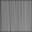

4143: Piece(P) : Label vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


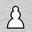

4358: Piece(b) : Label vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


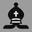

2581: Piece(B) : Label vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


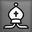

4497: Piece(Q) : Label vector: [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


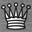

In [11]:
# Visualize a couple tiles
for i in np.random.choice(train_dataset.num_examples, 5):
    print "%d: Piece(%s) : Label vector: %s" % (i, hf.label2Name(train_dataset.labels[i]), train_dataset.labels[i])
    hf.display_array(np.reshape(train_dataset.images[i,:],[32,32]))

Looks good. Now that we've loaded the data, let's build up a simple softmax regression classifier based off of [this beginner tutorial](https://www.tensorflow.org/versions/v0.6.0/tutorials/mnist/beginners/index.html) on tensorflow.

In [35]:
x = tf.placeholder(tf.float32, [None, 32*32])
W = tf.Variable(tf.zeros([32*32, 13]))
b = tf.Variable(tf.zeros([13]))

y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 13])

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

init = tf.initialize_all_variables()


sess = tf.Session()
sess.run(init)

N = 10000
print "Training for %d steps..." % N
for i in range(N):
    batch_xs, batch_ys = train_dataset.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if ((i+1) % 500) == 0:
        print "\t%d/%d" % (i+1, N)
print "Finished training."

Training for 10000 steps...
	500/10000
	1000/10000
	1500/10000
	2000/10000
	2500/10000
	3000/10000
	3500/10000
	4000/10000
	4500/10000
	5000/10000
	5500/10000
	6000/10000
	6500/10000
	7000/10000
	7500/10000
	8000/10000
	8500/10000
	9000/10000
	9500/10000
	10000/10000
Finished training.


In [36]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "Accuracy: %g\n" % sess.run(accuracy, feed_dict={x: test_dataset.images, y_: test_dataset.labels})

Accuracy: 1



Looks like it memorized everything, let's look at the weights to get an idea of what it sees for each piece.

Visualization of Weights as negative(Red) to positive(Blue)
Piece:  


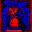

Piece: K


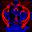

Piece: Q


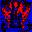

Piece: R


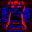

Piece: B


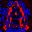

Piece: N


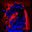

Piece: P


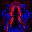

Piece: k


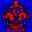

Piece: q


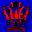

Piece: r


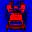

Piece: b


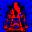

Piece: n


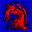

Piece: p


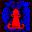

In [37]:
print "Visualization of Weights as negative(Red) to positive(Blue)"
for i in range(13):
    print "Piece: %s" % hf.labelIndex2Name(i)
    piece_weight = np.reshape(sess.run(W)[:,i], [32,32])
    hf.display_weight(piece_weight,rng=[-0.2,0.2])

Cool, you can see the shapes show up within the weights. Let's have a look at the failure cases to get a sense of what went wrong.

In [38]:
mistakes = tf.where(~correct_prediction)
mistake_indices = sess.run(mistakes, feed_dict={x: test_dataset.images,
                                                y_: test_dataset.labels}).flatten()

guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: test_dataset.images})

print "%d mistakes:" % mistake_indices.size

for idx in mistake_indices[:10]:
    a,b = test_dataset.labels[idx], guessed[idx]
    print "---"
    print "\t#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))
    print "Actual:",a
    print " Guess:",guess_prob[idx,:]
    print "---"

0 mistakes:


Some pretty blatement misses there, *more training data!* Also, lets look at several random selections, including successes.

#295 | Actual: ' ', Guessed: ' '


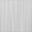

#262 | Actual: 'B', Guessed: 'B'


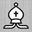

#149 | Actual: ' ', Guessed: ' '


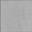

#175 | Actual: 'P', Guessed: 'P'


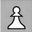

#230 | Actual: 'P', Guessed: 'P'


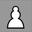

#285 | Actual: ' ', Guessed: ' '


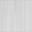

#56 | Actual: 'P', Guessed: 'P'


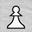

#164 | Actual: 'K', Guessed: 'K'


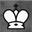

#133 | Actual: ' ', Guessed: ' '


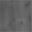

#98 | Actual: ' ', Guessed: ' '


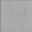

#264 | Actual: ' ', Guessed: ' '


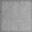

#29 | Actual: 'R', Guessed: 'R'


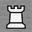

#223 | Actual: ' ', Guessed: ' '


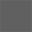

#122 | Actual: 'B', Guessed: 'B'


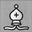

#67 | Actual: ' ', Guessed: ' '


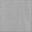

In [39]:
for idx in np.random.choice(test_dataset.num_examples,15,replace=False):
    a,b = test_dataset.labels[idx], guessed[idx]
    print "#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))

# Manual validation via screenshots on reddit
We'll eventually build a training/test/validation dataset of different proportions in one go, but for now, lets build a wrapper that given an image, returns a predicted FEN

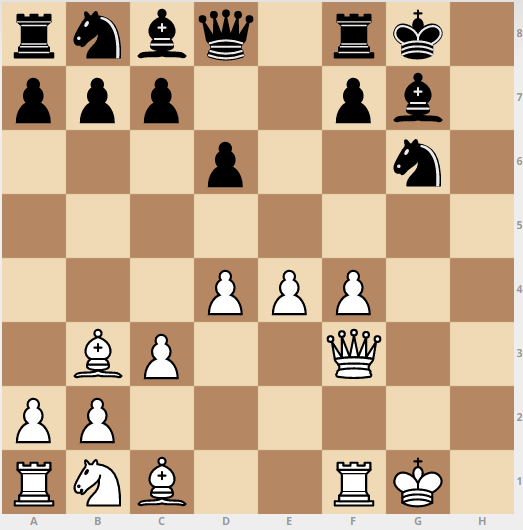

Let's see the 5th tile, corresponding to F1


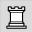

In [18]:
validate_img_path = 'reddit/aL64q8w.png'
img_arr = tensorflow_chessbot.loadImage(validate_img_path)
tiles = tensorflow_chessbot.getTiles(img_arr)

# See the screenshot
display(Image(validate_img_path))

# see one of the tiles
print "Let's see the 5th tile, corresponding to F1"
hf.display_array(tiles[:,:,5])


First 5 tiles
#0 | Actual: '?', Guessed: 'R'


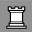

#1 | Actual: '?', Guessed: 'N'


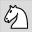

#2 | Actual: '?', Guessed: 'B'


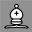

#3 | Actual: '?', Guessed: ' '


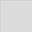

#4 | Actual: '?', Guessed: ' '


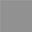

In [19]:
validation_set = np.swapaxes(np.reshape(tiles, [32*32, 64]),0,1)

guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: validation_set})

print "First 5 tiles"
for idx in range(5):
    guess = guessed[idx]
    print "#%d | Actual: '?', Guessed: '%s'" % (idx, hf.labelIndex2Name(guess))
    hf.display_array(np.reshape(validation_set[idx,:],[32,32]))

Oh my, that looks correct, let's generate a FEN string from the `guessed` results, and view that side by side with the screenshot!

FEN: rnbq1rk1/ppp11pb1/111p11n1/11111111/111PPP11/1BP11Q11/PP111111/RNB11RK1


Prediction: [Lichess analysis](http://www.lichess.org/analysis/rnbq1rk1/ppp11pb1/111p11n1/11111111/111PPP11/1BP11Q11/PP111111/RNB11RK1)

Actual


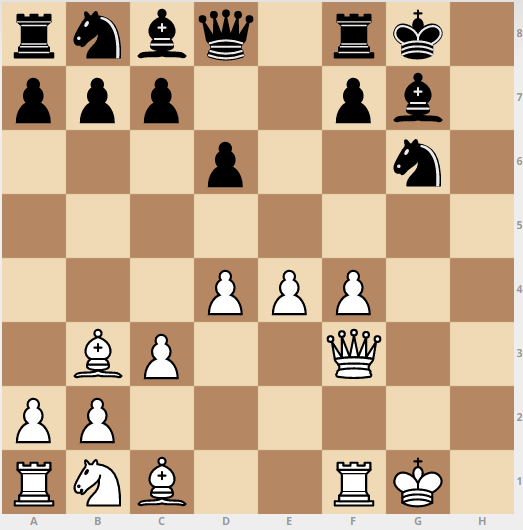

In [20]:
# guessed is tiles A1-H8 rank-order, so to make a FEN we just need to flip the files from 1-8 to 8-1
pieceNames = map(lambda k: '1' if k == 0 else hf.labelIndex2Name(k), guessed) # exchange ' ' for '1' for FEN
fen = '/'.join([''.join(pieceNames[i*8:(i+1)*8]) for i in reversed(range(8))])

print "FEN:",fen

# See our prediction as a chessboard
display(Markdown("Prediction: [Lichess analysis](http://www.lichess.org/analysis/%s)" % fen))
display(Image(url='http://www.fen-to-image.com/image/%s' % fen))

# See the original screenshot we took from reddit
print "Actual"
display(Image(validate_img_path))

# Predict from image url
A perfect match! Awesome, at this point even though we have enough to make predictions from several lichess boards (not all of them yet) and return a result. We can build our reddit chatbot now. Let's wrap this up into a single function call from a URL now.

In [32]:
def getPrediction(img):
    """Run trained neural network on tiles generated from image"""
    
    # Convert to grayscale numpy array
    img_arr = np.asarray(img.convert("L"), dtype=np.float32)
    
    # Use computer vision to get the tiles
    tiles = tensorflow_chessbot.getTiles(img_arr)
    if tiles == []:
        print "Couldn't parse chessboard"
        return ""
    
    # Reshape into Nx1024 rows of input data, format used by neural network
    validation_set = np.swapaxes(np.reshape(tiles, [32*32, 64]),0,1)

    # Run neural network on data
    guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: validation_set})
    
    # Convert guess into FEN string
    # guessed is tiles A1-H8 rank-order, so to make a FEN we just need to flip the files from 1-8 to 8-1
    pieceNames = map(lambda k: '1' if k == 0 else hf.labelIndex2Name(k), guessed) # exchange ' ' for '1' for FEN
    fen = '/'.join([''.join(pieceNames[i*8:(i+1)*8]) for i in reversed(range(8))])
    return fen

def makePrediction(image_url):
    """Given image url to a chessboard image, return a visualization of FEN and link to a lichess analysis"""
    # Load image from url and display
    img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url).read()))
    
    print "Image on which to make prediction: %s" % image_url
    hf.display_image(img)
    
    # Make prediction
    fen = getPrediction(img)
    display(Markdown("Prediction: [Lichess analysis](http://www.lichess.org/analysis/%s)" % fen))
    display(Image(url='http://www.fen-to-image.com/image/%s' % fen))
    print "FEN: %s" % fen    


## Make Predictions

All the boilerplate is done, the model is trained, it's time. I chose the first post I saw on reddit.com/chess with a chessboard (something our CV algorithm can do also): https://www.reddit.com/r/chess/comments/45inab/moderate_black_to_play_and_win/ with an image url of http://i.imgur.com/x6lLQQK.png

And awaayyy we gooo...

Image on which to make prediction: http://i.imgur.com/x6lLQQK.png


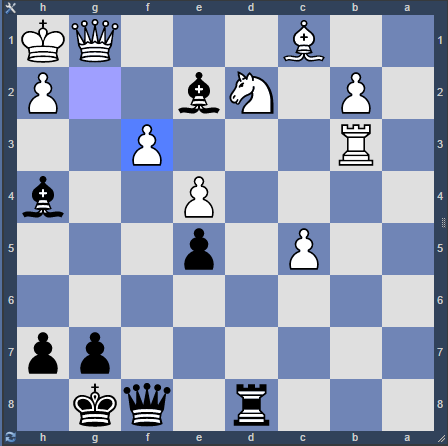

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/KQ111B11/P11bN1P1/11P111R1/b11P1111/111p1P11/11111111/pp111111/1kq1r111)

FEN: KQ111B11/P11bN1P1/11P111R1/b11P1111/111p1P11/11111111/pp111111/1kq1r111


In [40]:
makePrediction('http://i.imgur.com/x6lLQQK.png')

Fantastic, a perfect match! It was able to handle the highlighting on the pawn movement from G2 to F3 also. 

Now just for fun, let's try an image that is from a chessboard we've never seen before! Here's another on reddit: https://www.reddit.com/r/chess/comments/45c8ty/is_this_position_starting_move_36_a_win_for_white/

Image on which to make prediction: http://i.imgur.com/r2r43xA.png


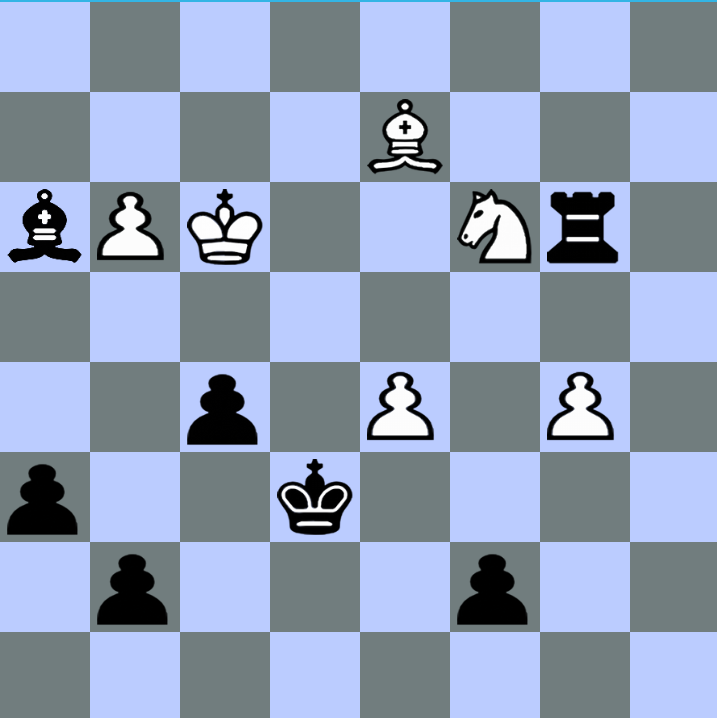

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/11111111/1111B111/bBK11Nr1/11111111/11b1P1P1/b11k1111/1b111b11/11111111)

FEN: 11111111/1111B111/bBK11Nr1/11111111/11b1P1P1/b11k1111/1b111b11/11111111


In [41]:
makePrediction('http://i.imgur.com/r2r43xA.png')

Hah, it thought the black pawns (on A3, B2, C4, and F2) were black bishops. This would be a pretty bad situation for white. But amazingly it predicted all the other pieces and empty squares correctly! This is pretty great, let's look at a few more screenshots taken lichess. Here's https://www.reddit.com/r/chess/comments/44q2n6/tactic_from_a_game_i_just_played_white_to_move/

Image on which to make prediction: http://i.imgur.com/gSFbM1d.png


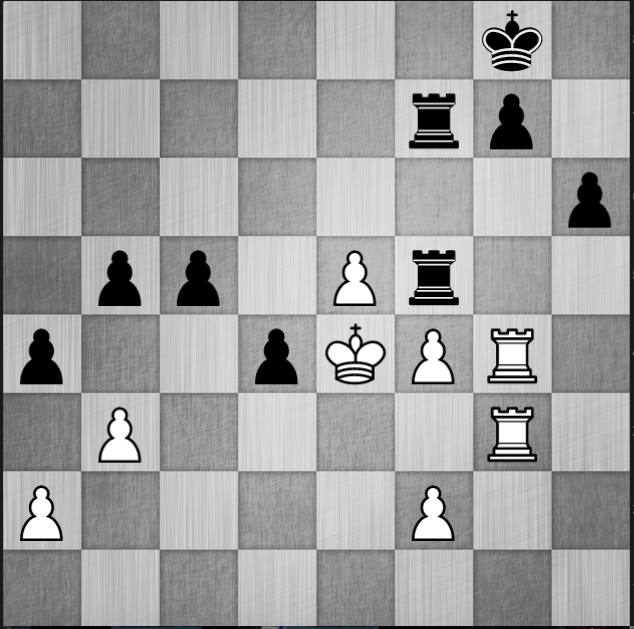

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/111111k1/11111rp1/1111111p/1pp1Pr11/p11pKPR1/1P1111R1/P1111P11/11111111)

FEN: 111111k1/11111rp1/1111111p/1pp1Pr11/p11pKPR1/1P1111R1/P1111P11/11111111


In [42]:
makePrediction('http://i.imgur.com/gSFbM1d.png')

Perfect match, as expected, when the validation images are based off of what the model trains, it'll do great, but if we use images from chess boards we haven't trained on, we'll see lots of mistakes. Mistakes are fun, lets see some.

## Trying with non-lichess images

Image on which to make prediction: http://imgur.com/oXpMSQI.png


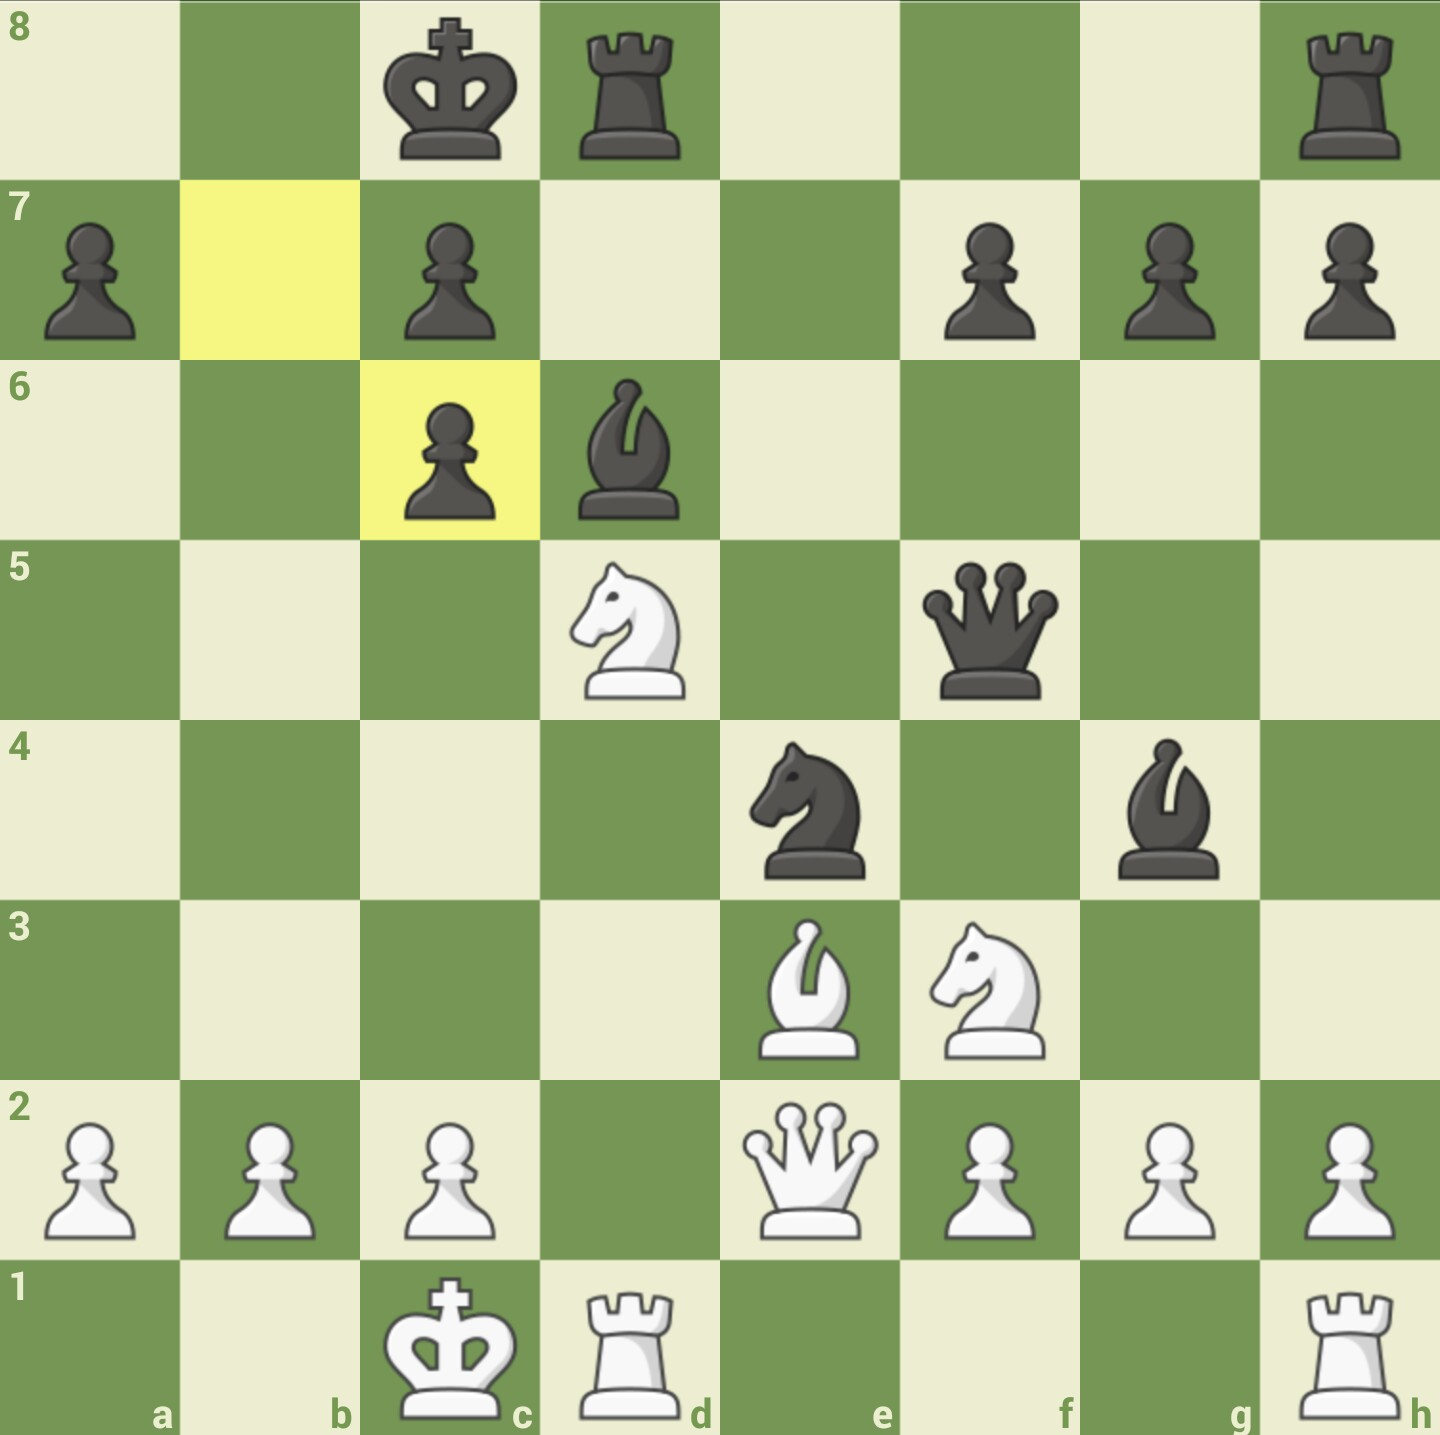

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/11nr111r/p1p11ppp/11pb1111/11111n11/1111n1b1/1111R111/1P111P1P/11P11111)

FEN: 11nr111r/p1p11ppp/11pb1111/11111n11/1111n1b1/1111R111/1P111P1P/11P11111


In [43]:
makePrediction('http://imgur.com/oXpMSQI.png')

Ouch, it missed most of them there, the training data didn't contain images from this site, which looks somewhat like chess.com, need more DATA!

Image on which to make prediction: http://imgur.com/qk5xa6q.png


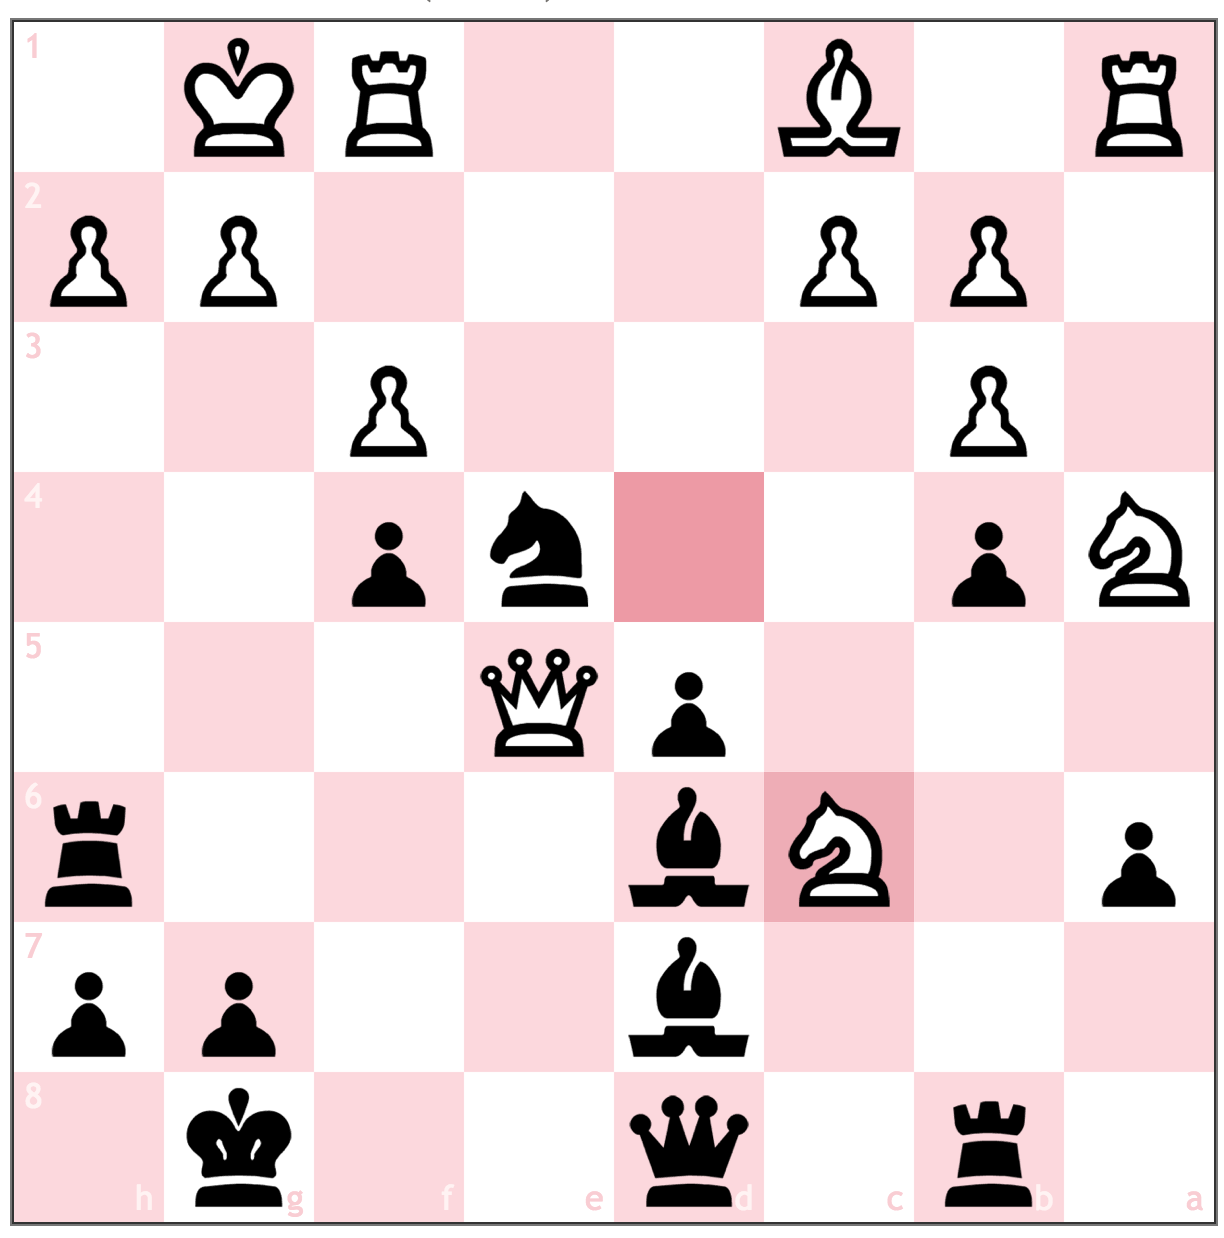

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/1nr11b1r/pp111pp1/11p111p1/11pn11pn/111qp111/r111bB1p/pp11b111/1n11q1r1)

FEN: 1nr11b1r/pp111pp1/11p111p1/11pn11pn/111qp111/r111bB1p/pp11b111/1n11q1r1


In [44]:
makePrediction('http://imgur.com/qk5xa6q.png')

Image on which to make prediction: http://imgur.com/u4zF5Hj.png


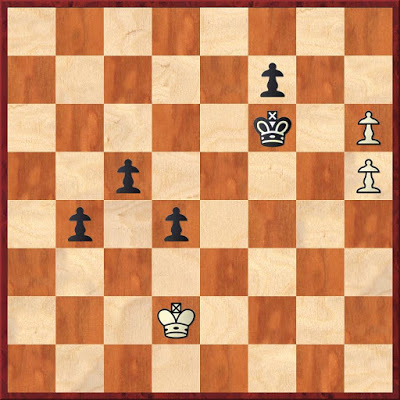

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/11111111/11111p11/11111R1P/11p11111/1p1p1111/11111111/111K1111/11111111)

FEN: 11111111/11111p11/11111R1P/11p11111/1p1p1111/11111111/111K1111/11111111


In [45]:
makePrediction('http://imgur.com/u4zF5Hj.png')

Image on which to make prediction: http://imgur.com/CW675pw.png


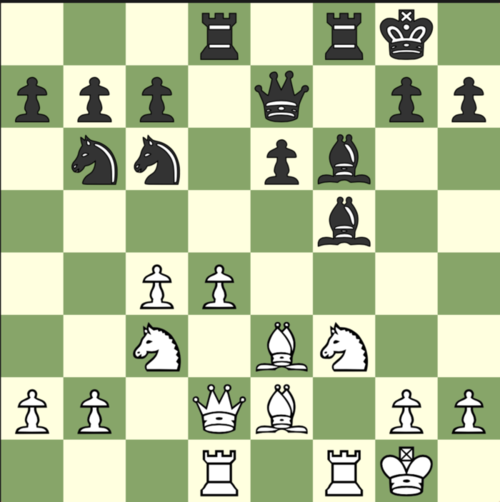

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Prediction: [Lichess analysis](http://www.lichess.org/analysis/111r1rn1/ppp1q1pp/1nn1pb11/11111b11/11bP1111/1111R111/bP1Qn1bP/111111K1)

FEN: 111r1rn1/ppp1q1pp/1nn1pb11/11111b11/11bP1111/1111R111/bP1Qn1bP/111111K1


In [46]:
makePrediction('http://imgur.com/CW675pw.png')

Ouch, tons of failures, interesting replacements, sometimes it's a missing piece, sometimes it's a white rook instead of a black king, or a bishop instead of a pawn, how interesting. Definitely time to collect more data